## **Smart Waste Classification Using Machine Learning**

**Student:** Alia Bazeel  
**Dataset:** Trashify Image Dataset (Kaggle)  
**Objective:** Develop a machine learning model capable of classifying waste into three categories: Metal, Paper, and Plastic.  

Proper waste segregation is a critical step in promoting sustainable recycling practices and reducing environmental pollution. Manual sorting of waste is often slow, error-prone, and resource-intensive. This project leverages a convolutional neural network (MobileNetV2) to automatically classify images of waste into three categories: Metal, Paper, and Plastic. Using the Trashify dataset from Kaggle, the model is trained with data augmentation and fine-tuning to achieve reliable performance. The notebook demonstrates the workflow from data preprocessing and model training to evaluation and deployment through an interactive Gradio interface, providing predicted classes and confidence distributions.

## **Step 1: Import Libraries**
#### *Import Python libraries for image preprocessing, model construction, evaluation, and interactive demonstration with Gradio.*

In [71]:
# Numerical & Data
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

# Interface
import gradio as gr
from PIL import Image

##  **Step 2: Parameters**
#### *Define image dimensions, batch size, number of epochs, and class labels.*

In [70]:
img_height, img_width = 224, 224
batch_size = 32
epochs = 12
class_names = ['metal', 'paper', 'plastic']

## **Step 3: Load and Check Data**
#### *Load the Trashify dataset and summarize its structure, including number of classes and images per class.*

In [74]:
trash_data = "/kaggle/input/trashify-image-dataset/trashify-image-dataset"

In [75]:
# Initial check - see folder structure
import os
os.listdir(trash_data)

['metal', 'paper', 'plastic']

## **Step 4: Data Preprocessing and Augmentation**
#### *Images from the Trashify dataset are resized, normalized, and augmented using rotation, shifts, shear, zoom, brightness adjustments, and horizontal flips. This strengthens generalization and helps the model distinguish visually similar waste items.*

In [76]:
# Data generator with augmentation & validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    validation_split=0.2  # 20% validation
)

In [78]:
# Training generator
train_generator = datagen.flow_from_directory(
    trash_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 285 images belonging to 3 classes.


In [79]:
# Validation generator
val_generator = datagen.flow_from_directory(
    trash_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 71 images belonging to 3 classes.


## **Step 5: Model Construction with Fine-Tuning**
#### *MobileNetV2, pretrained on ImageNet, is used as the base model. The last 20 layers are unfrozen for fine-tuning, while earlier layers retain pretrained weights. Additional layers include GlobalAveragePooling2D, Dense, and Dropout, allowing the network to adapt to the Trashify dataset.*

In [80]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [81]:
# Freeze all except last 20 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [82]:
# Build full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

In [84]:
# Compile
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [85]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 1,370,435 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

## **Step 6: Model Training**
#### *The model is trained for 12 epochs using augmented data. Training and validation accuracy are monitored to prevent overfitting and ensure robust learning.*

In [90]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.7317 - loss: 0.6351 - val_accuracy: 0.7465 - val_loss: 0.7050
Epoch 2/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7840 - loss: 0.6087 - val_accuracy: 0.7746 - val_loss: 0.6692
Epoch 3/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.7963 - loss: 0.5827 - val_accuracy: 0.6620 - val_loss: 0.7422
Epoch 4/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.8422 - loss: 0.5369 - val_accuracy: 0.6761 - val_loss: 0.7252
Epoch 5/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.8331 - loss: 0.4782 - val_accuracy: 0.7183 - val_loss: 0.6527
Epoch 6/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8401 - loss: 0.5065 - val_accuracy: 0.7324 - val_loss: 0.6307
Epoch 7/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8198 - loss: 0.4451 - val_accuracy: 0.7606 - val_loss: 0.6239
Epoch 8/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.8394 - loss: 0.4296 - val_accuracy: 0.7606 - val_loss: 0.6309
Epoch 9/

## **Step 7: Model Evaluation**
#### *Evaluate performance with accuracy and loss curves, confusion matrix, and classification report. This shows how well the model distinguishes Metal, Paper, and Plastic and identifies common misclassifications.*

## -------- 7.1. *Plot accuracy and loss*

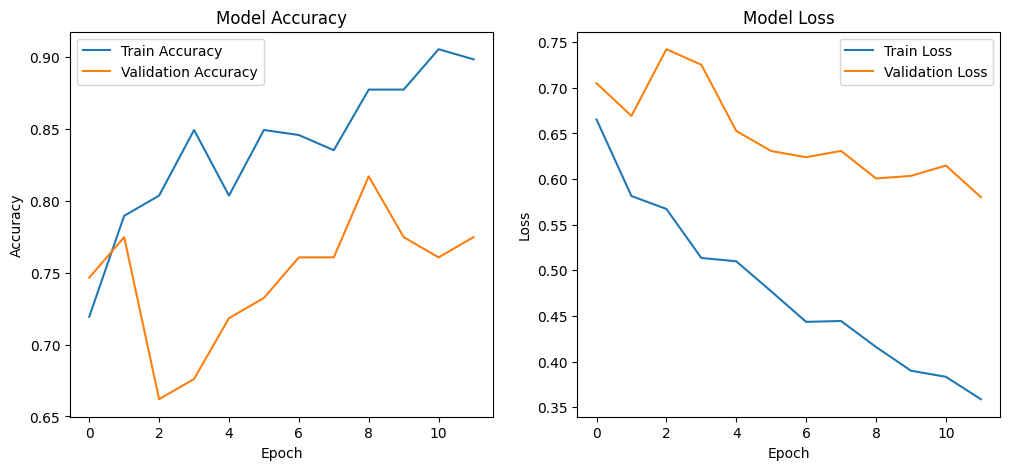

In [91]:
# Plot accuracy and loss

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## -------- 7.2. *Confusion Matrix*

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


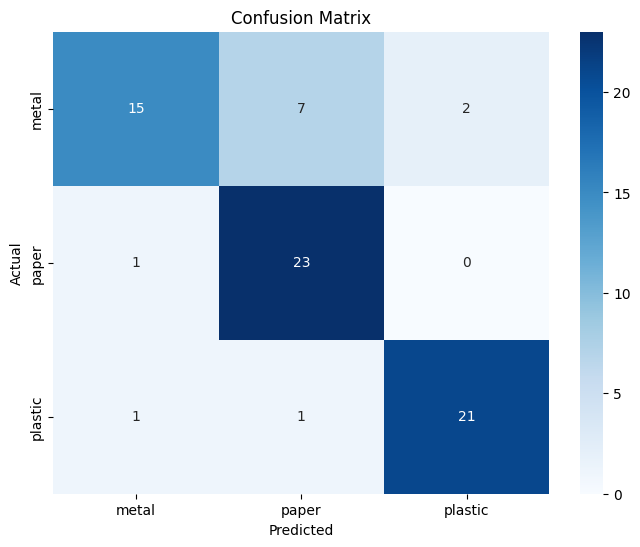

In [92]:
#Confusion Matrix

val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## -------- 7.3. *Classification Report*

In [93]:
#Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       metal       0.88      0.62      0.73        24
       paper       0.74      0.96      0.84        24
     plastic       0.91      0.91      0.91        23

    accuracy                           0.83        71
   macro avg       0.85      0.83      0.83        71
weighted avg       0.84      0.83      0.83        71



## **Step 8: Gradio Interactive Demo**
#### *An interactive Gradio interface allows users to upload waste images and receive real-time predictions. The top three predicted categories are displayed alongside a confidence distribution bar chart. Example images from a custom dataset are included for instant testing, demonstrating the model’s usability and interpretability.*

In [98]:
# Emoji labels (for better UI)
class_emojis = {
    "metal": "🛢️ Metal",
    "paper": "📄 Paper",
    "plastic": "🧴 Plastic"
}

# Prediction function
def predict_trash(image):
    img = image.resize((img_height, img_width))
    img_array = np.array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0]
    results = {class_emojis[class_names[i]]: float(pred[i]) for i in range(len(class_names))}
    return results

# Function to generate Matplotlib bar plot
def plot_confidence(pred_dict):
    categories = list(pred_dict.keys())
    confidence = [v*100 for v in pred_dict.values()]
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(categories, confidence, color=['#4CAF50','#2196F3','#FF9800'])
    ax.set_ylim(0, 100)
    ax.set_ylabel("Confidence (%)")
    ax.set_title("Prediction Confidence Distribution")
    return fig

# Gradio Interface
with gr.Blocks() as demo:
    gr.HTML("<title>♻️ Smart Trash Classifier</title>")

    gr.Markdown(
        "<h1 style='text-align:center;'>♻️ Smart Trash Classifier</h1>"
        "<p style='text-align:center;'>"
        "Upload an image of waste to classify it as "
        "<b>Metal</b>, <b>Paper</b>, or <b>Plastic</b>. "
        "Prediction confidence scores are shown below."
        "</p>"
        "<p style='text-align:center;'>"
        "Use the example images at the bottom for testing (if required)."
        "</p>"
    )

    with gr.Row():
        input_image = gr.Image(type="pil", label="Upload Waste Image")
        prediction_label = gr.Label(num_top_classes=3, label="Predicted Class (Top 3)")
    
    confidence_plot = gr.Plot(label="Prediction Confidence Distribution")

    input_image.change(
        fn=lambda img: (predict_trash(img), plot_confidence(predict_trash(img))),
        inputs=input_image,
        outputs=[prediction_label, confidence_plot]
    )

    gr.Markdown("### Example Images (Drag & Drop to Test)")
    gr.Examples(
        examples=[
            "/kaggle/input/aliab-test-image/download.jpg",
            "/kaggle/input/aliab-test-image/orora-aluminium-can-375ml.png",
            "/kaggle/input/aliab-test-image/images.jpg"
        ],
        inputs=input_image
    )

demo.launch(share=True, inbrowser=True)

* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://d16e7f4120e570874c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128738 (\N{OIL DRUM}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 129524 (\N{LOTION BOTTLE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128738 (\N{OIL DRUM}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 129524 (\N{LOTION BOTTLE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128738 (\N{OIL DRUM}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 129524 (\N{LOTION BOTTLE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128738 (\N{OIL DRUM}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 129524 (\N{LOTION BOTTLE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128738 (\N{OIL DRUM}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 129524 (\N{LOTION BOTTLE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128738 (\N{OIL DRUM}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 129524 (\N{LOTION BOTTLE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128738 (\N{OIL DRUM}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)
/usr/local/lib/python3.12/dist-packages/gradio/processing_utils.py:81: UserWarning: Glyph 129524 (\N{LOTION BOTTLE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_bytes, format=fmt)


## **Conclusion**


The model is able to classify waste images into **Metal**, **Paper**, and **Plastic** really well. Using **MobileNetV2** with transfer learning meant the model could use pre-learned visual features, so it didn’t need tons of data to work properly. I also used **data augmentation**—like rotation, shifting, zooming, and brightness changes—so the model can handle real-life variations in how waste might look, like different angles, lighting, or sizes.

By fine-tuning the last layers of the network, the model learned to pick up subtle differences between categories, for example, telling plastic apart from metal. The evaluation using accuracy, loss curves, confusion matrix, and classification report shows that it performs reliably on images it hasn’t seen before.

The **Gradio interface** makes this easy to try out. You can upload an image and see the top three predicted classes along with confidence scores, plus there are example images for testing. This makes it simple to see how well the model works in practice and makes it more interactive.

Overall, this project shows that machine learning can **help automate waste sorting**, reduce human errors, and make recycling more efficient. It’s a simple step toward using AI for sustainable practices, and it’s fun to see it working in real time!